# Kruskal’s Algorithm

The content of the following notebook is based on [this R course](https://web.archive.org/web/20141114045919/http://www.stats.ox.ac.uk/~konis/Rcourse/exercise1.pdf) and [Hage et al. (1996) paper](./hage1996.pdf).

### Introduction: Similarity of Polynesian islands

In 1938 Burrows published the results of an extensive archaeological analysis of Polynesian
islands. By examining cultural traits and complexes including artifacts (tools, canoe types,
bark cloth, etc.), aspects of social organization (languages, kinship practices), and religious
ideas, he identified 4 subgroups in Polynesia.

- Western Polynesia (Samoa, Tonga)
- Central Polynesia (Society Islands, Tuamotus, Southern Cooks, Australs, Rapa, Hawaii)
- Marginal Polynesia (New Zealand, Easter Island, Marqueses, Mangareva)
- Intermediate Polynesia (Northern Cooks)

In 1992 Irwin proposed that the level of similarity between Polynesian cultures is proportional
to the ease of travel between them. In other words, the more remote two islands are, the less
similar their cultures. 

Below you can find the Irwin's close proximity analysis of the mutual accessibility network of Polynesian islands.


![](./irving_map.png)

In support of the hypothesis that accessibility is predictive of patterns of cultural similarity, Irwin
notes parallels between his close proximity network and the subgroupings in Polynesia identified
by Burrows (1938). Unfortunately, the Irvin's network contains many superfluous edges and hence cycles which tend to obscure such parallels.

### Task 1: Implement Maximum Weight Spanning Tree

**The assignment is to test Irwin’s hypothesis by computing a maximum weight spanning tree
for the accessibility of these 13 islands.**

The following matrix gives the mutual accessibility (as computed by
Irwin) between the islands in the study.

In [1]:
header = ['TON', 'SAM', 'SCK', 'NCK', 'SOC', 'MRQ', 'TUA', 'MGR', 'AUS', 'RAP', 'HAW', 'EAS', 'NZ']

matrix = [
    [0, 0.44, 0.32, 0.18, 0.22, 0.18, 0.24, 0.09, 0.16, 0.10, 0.11, 0.03, 0.23],
    [0.44, 0, 0.27, 0.23, 0.17, 0.15, 0.17, 0.10, 0.19, 0.11, 0.19, 0.05, 0.24],
    [0.32, 0.27, 0,  0.23, 0.54, 0.30, 0.46, 0.14, 0.38, 0.18, 0.15, 0.08, 0.24],
    [0.18, 0.23, 0.23, 0,  0.23, 0.15, 0.21, 0.11, 0.18, 0.14, 0.11, 0.05, 0.10],
    [0.22, 0.17, 0.54, 0.23, 0, 0.41, 0.98, 0.22, 0.71, 0.21, 0.20, 0.09, 0.20],
    [0.18, 0.15, 0.30, 0.15, 0.41, 0, 0.54, 0.20, 0.34, 0.15, 0.13, 0.10, 0.12],
    [0.24, 0.17, 0.46, 0.21, 0.98, 0.54, 0, 0.34, 0.63, 0.21, 0.21, 0.11, 0.24],
    [0.09, 0.10, 0.14, 0.11, 0.22, 0.20, 0.34, 0, 0.23, 0.21, 0.08, 0.14, 0.08],
    [0.16, 0.19, 0.38, 0.18, 0.71, 0.34, 0.63, 0.23, 0, 0.33, 0.19, 0.06, 0.21],
    [0.10, 0.11, 0.18, 0.14, 0.21, 0.15, 0.21, 0.21, 0.33, 0, 0.05, 0.10, 0.09],
    [0.11, 0.19, 0.15, 0.11, 0.20, 0.13, 0.21, 0.08, 0.19, 0.05, 0,  0.03, 0.09],
    [0.03, 0.05, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.06, 0.10, 0.03, 0, 0.00],
    [0.23, 0.24, 0.24, 0.10, 0.20, 0.12, 0.24, 0.08, 0.21, 0.09, 0.09, 0.00, 0]
]


In [2]:
from collections import namedtuple

Edge = namedtuple('Edge', ['weight', 'island1', 'island2'])


def matrix_to_edges(header, matrix):
    G = []
    for i, row in enumerate(matrix):
        for j, weight in enumerate(row):
            if weight != 0 or i == j:
                island1 = header[i]
                island2 = header[j]
                G.append(Edge(weight=weight, island1=island1, island2=island2))
    return G

G = matrix_to_edges(header, matrix)

One method for computing the maximum weight spanning tree of a network G – due to Kruskal
– can be summarized as follows.

1. Sort the edges of $G$ into decreasing order by weight. Let $T$ be the set of edges comprising the maximum weight spanning tree. Set $T = ∅$.
2. Add the first edge to $T$.
3. Add the next edge to $T$ if and only if it does not form a cycle in $T$. If there are no remaining edges exit and report $G$ to be disconnected.
4. If $T$ has $n−1$ edges (where $n$ is the number of vertices in $G$) stop and output $T$. Otherwise go to step 3.

In [8]:
class DisJointSets():
    def __init__(self,N):
        # Initially, all elements are single element subsets
        self._parents = [node for node in range(N)]
        self._ranks = [1 for _ in range(N)]
    
    def find(self, u):
        while u != self._parents[u]: 
            # path compression technique
            self._parents[u] = self._parents[self._parents[u]]
            u = self._parents[u]
        return u
    
    def connected(self, u, v):
        return self.find(u) == self.find(v)
    
    def union(self, u, v):
        # Union by rank optimization
        root_u, root_v = self.find(u), self.find(v)
        if root_u == root_v:
            return True
        if self._ranks[root_u] > self._ranks[root_v]:
            self._parents[root_v] = root_u
        elif self._ranks[root_v] > self._ranks[root_u]:
            self._parents[root_u] = root_v
        else:
            self._parents[root_u] = root_v
            self._ranks[root_v] += 1
        return False

def kruskal(edges, header):
    # Sort the edges by weight
    edges.sort(key=lambda edge: edge.weight, reverse=True)
    #print(edges)
    djsets = DisJointSets(len(header))
    
    vertices = {}
    i = 0
    for island in header:
        vertices[island] = i
        i += 1
        
    num_vertices = len(header)
    
    res = []
    for edge in edges:
        if (not djsets.connected(vertices[edge.island1], vertices[edge.island2])):
            djsets.union(vertices[edge.island1], vertices[edge.island2])
            res.append(edge)
    
    return res   
    # TODO: Implement kruskal algorithm
    

# Example usage
mst = kruskal(G, header)

### Task 2
Draw the maximum weight spanning tree. Use dashed lines for the $k$ edges with the smallest weights (where $k$ is a number you pick) to emphasize the clusters. You can use the coordinates given below to plot the islands in their geographical distance.

In [1]:
# TODO: Plot your MST

If you want you can use the following coordinates and plot the results on a map.

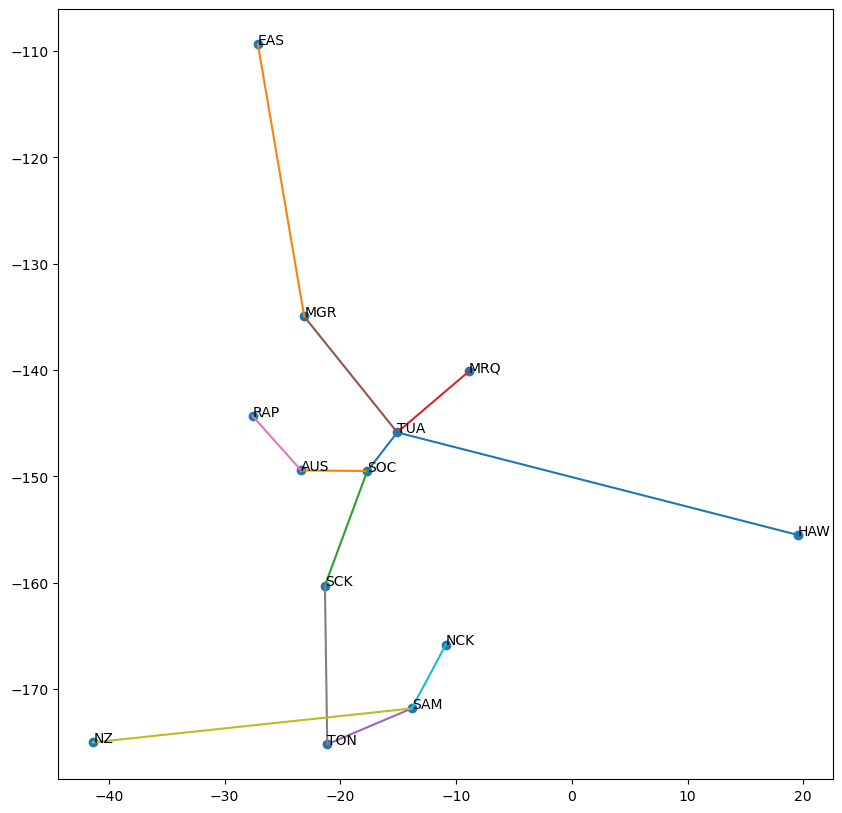

In [9]:
locations = [
  (-21.13, -175.20, "TON"),
  (-13.83, -171.83, "SAM"),
  (-21.33, -160.27, "SCK"),
  (-10.88, -165.82, "NCK"),
  (-17.67, -149.50, "SOC"),
  (-8.89, -140.13, "MRQ"),
  (-15.08, -145.87, "TUA"),
  (-23.12, -134.97, "MGR"),
  (-23.38, -149.45, "AUS"),
  (-27.58, -144.33, "RAP"),
  (19.52, -155.51, "HAW"),
  (-27.12, -109.37, "EAS"),
  (-41.35, -175.02, "NZ")
]
islands = {}
Island = namedtuple('Island', ['x', 'y'])
for i in locations:
    islands[i[2]] = Island(i[0], i[1])


import matplotlib.pyplot as plt



fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
x = [i[0] for i in locations]
y = [i[1] for i in locations]
ax.scatter(x, y)

for i in locations:
    ax.annotate(i[2], (i[0], i[1]))

for i in mst:
    x1 = islands[i.island1].x
    y1 = islands[i.island1].y
    x2 = islands[i.island2].x
    y2 = islands[i.island2].y
    ax.plot((x1, x2), (y1, y2), '-')

plt.show()

### Task 3
Compare the implied clusters with those given in Burrows’ study. Additionally, compare your results to Figure 3 in the Hage et al. paper. What are the differences? Is your clutering in agreement with what Burrows suggested?

The only difference between my results and the results from Figure 3 in the Hege et al. paper is that NZ is connected to SAM instead of SCK. Both edges have the same weight (0.24) so my result agrees with the one in the paper. 

I don't know how a tree corresponds to clustering but clusters provided in Burrows' study definitely don't match my tree.